<a href="https://colab.research.google.com/github/SchmidtdIlya/Attempt_optimizer/blob/main/attempt5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----
#Гамильтониан на scipy



In [ ]:
from scipy.sparse import linalg
from scipy import sparse
def sigma_k(k,n):
    left=sparse.eye(2**k)
    right=sparse.eye(2**(n-1-k))
    c=sparse.kron(left,sparse.csr_matrix(np.array([[1,0],[0,-1]])))
    return sparse.kron(c,right)
def ising(J,h,N):
    r=sparse.csr_matrix((2**N,2**N))
    for i in range(N-1):
        r+=J*sigma_k(i,N)*sigma_k(i+1,N)
        r-=h*sigma_k(i,N)
    r-=h*sigma_k(N-1,N)
    return r

In [ ]:
example=ising(-0.5,1.13,20)
solut=linalg.eigs(example,k=19,which='SR')

In [ ]:
solut[0].min()

(-32.0999999999999+0j)

In [ ]:
val, vecs = eigsh(example, k=19, which='SA')
val.min()

-32.09999999999991

In [ ]:
solut[0]

array([-32.1 +0.00000000e+00j, -28.84+0.00000000e+00j,
       -28.84+0.00000000e+00j, -27.84+0.00000000e+00j,
       -27.84+0.00000000e+00j, -27.84+0.00000000e+00j,
       -26.58+0.00000000e+00j, -27.84+0.00000000e+00j,
       -26.58+0.00000000e+00j, -27.84+0.00000000e+00j,
       -27.84+0.00000000e+00j, -27.84+0.00000000e+00j,
       -27.84+0.00000000e+00j, -27.84+0.00000000e+00j,
       -27.84+0.00000000e+00j, -27.84+0.00000000e+00j,
       -27.84+1.17830183e-14j, -27.84-1.17830183e-14j,
       -27.84+0.00000000e+00j])

In [ ]:
p=solut[1]*solut[1].conj()
def to_bit(p):
    size=int(np.log2(p.shape[0]))
    bit_num=np.where(p==p.max())[0][0]
    s=f"{ bit_num:b}"
    s="0"*(size-len(s))+s
    return s

In [ ]:
to_bit(p)

'00000000000000000000'

#Разное взаимодействие

In [ ]:
j=np.array([ 7., -5., -4.,  1.,  3.,  3.,  6.,  7.,  2.,  8.,  4.,  
        -0.1, -1.,  8.,  6.,  4., -1., 7.,  9.,  7.])

In [ ]:
def ising(J,h,N):
    r=sparse.csr_matrix((2**N,2**N))
    for i in range(N-1):
        r+=J[i]*sigma_k(i,N)*sigma_k(i+1,N)
        r-=h*sigma_k(i,N)
    r-=h*sigma_k(N-1,N)
    return r
at2=ising(j,0,20)
val, vecs = eigsh(at2, k=1, which='SA')
val.min()

-86.09999999999982

In [ ]:
to_bit(vecs)

'10001010101000101101'

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(H_matrix)
eigenvalues, eigenvectors

(array([-2.82842712, -2.        ,  2.82842712,  2.        ]),
 array([[ 6.53281482e-01, -7.07106781e-01,  2.70598050e-01,
          6.02732551e-17],
        [-2.70598050e-01, -4.33532422e-16,  6.53281482e-01,
          7.07106781e-01],
        [-2.70598050e-01, -5.85556840e-16,  6.53281482e-01,
         -7.07106781e-01],
        [ 6.53281482e-01,  7.07106781e-01,  2.70598050e-01,
          2.26806709e-16]]))



---

#Использование драйвера оптимизации NetKet


In [ ]:
import netket as nk
import numpy as np
import jax
from netket.operator.spin import sigmax,sigmaz #,sigmay
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

In [ ]:
import os 
os.environ["JAX_PLATFOR_NAME"]="gpu"

In [ ]:
N=10
at=nk.hilbert.Spin(s=0.5,N=N)
one=at.random_state(jax.random.PRNGKey(0),3)
one

DeviceArray([[ 1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.],
             [ 1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.],
             [-1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.]],            dtype=float32)

In [ ]:
J=-0.5
H=sum([J*sigmax(at,i)for i in range(N)])
H

LocalOperator(dim=10, #acting_on=10 locations, constant=0.0, dtype=float64)

In [ ]:
E=-1
H+=sum([E*sigmaz(at,i)*sigmaz(at,(i+1)%N)for i in range (N)])
sm=H.to_sparse() #разряженная матрица
val, vecs = eigsh(sm, k=2, which='SA') # SA- алгебраическое наименьшее
val #два самых низких по энергии собственных состояния

array([-10.63560441, -10.63528368])

In [ ]:
nk.exact.lanczos_ed(H, k=2)

array([-10.63560441, -10.63528368])

In [ ]:
nk.graph.Hypercube(10,1,pbc=True).n_nodes

10

In [ ]:
k=nk.graph.Hypercube(20,1,pbc=True)
att=nk.hilbert.Spin(0.5,k.n_nodes)
oper=nk.operator.Ising(att,h=1.13,J=J,graph=k)
exact_solution=nk.exact.lanczos_ed(oper)

s=nk.sampler.MetropolisLocalNumpy(att)
model=nk.models.Jastrow()
optimizer=nk.optimizer.Sgd(0.05)
sr=nk.optimizer.SR()
vmc=nk.driver.VMC(oper,optimizer,s,model,n_samples=1008,preconditioner=sr)

In [ ]:
log=nk.logging.RuntimeLog()
vmc.run(300,out=log)

100%|██████████| 300/300 [01:20<00:00,  3.70it/s, Energy=-23.72050-0.00000j ± 0.00041 [σ²=0.00017, R̂=1.0114]]


(RuntimeLog():
  keys = ['Energy'],)

In [ ]:
exact_solution

array([-23.72044953])

In [ ]:
-abs(log.data['Energy']['Mean'].min())

-23.725042803386202

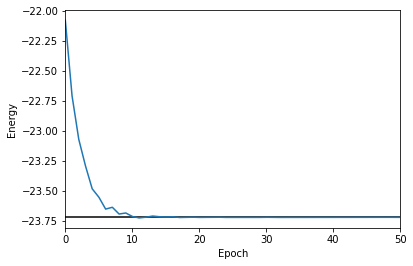

In [ ]:
from netket.vqs import exact
plt.plot(np.linspace(0,300,300), np.real(log.data['Energy']['Mean']))
plt.hlines(exact_solution,0,300)
plt.ylabel('Energy')
plt.xlabel('Epoch')
plt.xlim([0,50])
plt.show()

----
#Аналогичная реализация на D-Wave 
### API (.)
Qiskit

In [ ]:
#%pip install dwave-ocean-sdk #та же проблема, что и с openAI

In [ ]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [ ]:
# set integers C, where 2 parts == 27
C = [2, 10, 3, 8, 5, 7, 9, 5, 3, 2]
N = len(C)
h1 = {}
J1 = {}
for i in range(N):
    h1[i] = 0
    for j in range(i + 1, N):
        J1[i, j] = 2 * C[i] * C[j]
from dwave.system import DWaveSampler, EmbeddingComposite
#sampler = EmbeddingComposite(DWaveSampler())
#response.record

In [ ]:
x=np.random.randint(0.,271.1,size=(5000, 100))
z = np.zeros((5000,5000))
x_mean = np.mean(x,axis=0)
x_std = np.std(x,axis=0,ddof=0)
print(x_mean.shape,x_std.shape)
for i in range(100):
  z[:,i]=x_mean[i]-x[:,i]
cov=np.cov(z,rowvar=False)
from numpy import linalg as la
U,sigma,VT=la.svd(cov)


In [ ]:
s1=linalg.eigs(cov,k=1,which='SR')
abs(s1[0])

array([7.12243154e-14])

In [ ]:
import dimod
h = {0: 145.0, 1: 122.0, 2: 122.0, 3: 266.0, 4: 266.0, 5: 266.0, 6: 242.5, 7: 266.0, 8: 386.5, 9: 387.0, 10: 386.5}
J = {(0, 3): 24.0, (0, 4): 24.0, (0, 5): 24.0, (0, 7): 24.0, (0, 8): 24.0, (0, 9): 24.0, (0, 10): 24.0, (1, 3): 24.0, (1, 5): 24.0, (1, 6): 24.0, (1, 8): 24.0, (1, 9): 24.0, (1, 10): 24.0, (2, 4): 24.0, (2, 6): 24.0, (2, 7): 24.0, (2, 8): 24.0, (2, 9): 24.0, (2, 10): 24.0, (3, 4): 24.0, (3, 5): 48.0, (3, 6): 24.0, (3, 7): 24.0, (3, 8): 48.0, (3, 9): 48.0, (3, 10): 48.0, (4, 5): 24.0, (4, 6): 24.0, (4, 7): 48.0, (4, 8): 48.0, (4, 9): 48.0, (4, 10): 48.0, (5, 6): 24.0, (5, 7): 24.0, (5, 8): 48.0, (5, 9): 48.0, (5, 10): 48.0, (6, 7): 24.0, (6, 8): 48.0, (6, 9): 48.0, (6, 10): 48.0, (7, 8): 48.0, (7, 9): 48.0, (7, 10): 48.0, (8, 9): 72.0, (8, 10): 72.0, (9, 10): 72.0}
cI = 1319.5

model_ising = dimod.BinaryQuadraticModel.from_ising(h, J, offset=cI)
exactSampler = dimod.reference.samplers.ExactSolver()
exactSamples = exactSampler.sample(model_ising)

In [ ]:
results=exactSamples
energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]
samples = [datum.sample for datum in results.data(
        ['sample'] )]

In [ ]:
min(energies)

5.0

In [ ]:
samples

In [ ]:
exactSamples

SampleSet(rec.array([([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 144., 1),
           ([ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],  98., 1),
           ([ 1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1], 102., 1), ...,
           ([ 1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1],  58., 1),
           ([ 1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1],  54., 1),
           ([-1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1], 100., 1)],
          dtype=[('sample', 'i1', (11,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(range(0, 11)), {}, 'SPIN')

In [ ]:
%pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.9/929.9 KB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 

In [ ]:
from numpy import *
from qiskit import *
import matplotlib.pyplot as plt

from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

state_0=array([]);
state_1=array([]);
phase_data=array([]);
q = QuantumRegister(1)
c = ClassicalRegister(1)
N_phase=20; # Step number of phase
shots=500; # Number of repetitions of each circuit

for i in range(N_phase):
    mz = QuantumCircuit(q,c) #Define circuit
    phase = 2*(i-1)*pi/15; # Step width of the phase = pi/15
    phase_data = append(phase_data,phase); 
    # Perform Mach-Zehnder interferometer
    mz.u(pi/2,pi/2,-pi/2,q); # Beam splitter BS1
    mz.p(-phase, q); # Phase shifter
    mz.u(pi/2,pi/2,-pi/2,q); # Beam splitter BS2
    mz.measure([0],[0]) # perform measurement
    job = execute(mz, least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 4 and not b.configuration().simulator and b.status().operational==True)), shots=500) # Perform experiment for 500 repetitions 
    result = job.result()
    data = result.get_counts();
    # Record probability to find each state in "state_0" and "state_1" 
    state_0=append(state_0,data['0']/shots); 
    state_1=append(state_1,data['1']/shots);



#Print probability to find each state
print(phase_data) # Phase
print(state_0) # Probability to find state |0>
print(state_1) # Probability to find state |1>

In [ ]:
from qiskit import *
import numpy as np
from qiskit import QuantumCircuit
q= QuantumRegister(1)
c=ClassicalRegister(1)
mz=QuantumCircuit(q,c)
phase = 2*(i-1)*np.pi/15;
phase_data = append(phase_data,phase); 

mz.u(pi/2,pi/2,-pi/2,q); # Beam splitter BS1
mz.p(-phase, q); # Phase shifter
mz.u(pi/2,pi/2,-pi/2,q); # Beam splitter BS2
mz.measure([0],[0])

In [ ]:
%pip install pylatexen



---


#Mach-Zender modulation


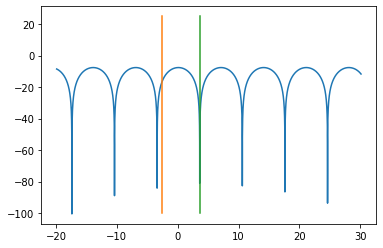

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
Offset=0.12
Vpi=7
ExtraIL=-10
lim_superior=3.73
lim_inferior=-2.6
frf1 = 29.0*1e9 
frf2  = 9.8*1e9                 # Frequency 2               [GHz]
fbase = 0.1e9                      # ?
Nfft  = 2**12                      # Number of symbols
fs    = Nfft*fbase                 # Define sampling frequency [Hz]
Nfft  = Nfft*(2**7)                 # Number of samples
Ts    = 1/fs                       # Sampling period           [s]
tvec  = np.arange(0,(Nfft-1)*Ts+Ts,Ts)           # Time vector    
fd    = np.linspace(-0.5, 0.5, Nfft)  # Discrete Frequency        [Hz]
f     = 2*fbase
fvec  = fd*fs                      # Frequency vector          [Hz]
freq  = fvec*1e-9

Pin_dB=14
Pin=10**((Pin_dB-30)/10)
Impedance=50
Vin=np.sqrt(2* Impedance * Pin)
frf=1
Vpi=3.5
IL=10**((8.6+20+3+ExtraIL)/10)
# IL=IL+1
Resp=0.9 #Responsividad

VV=np.linspace(-20,30,50000)
TV=0.5*(1+np.cos(np.pi*(VV)/Vpi))/IL
TV_dB=10*np.log10(0.5*(1+np.cos(np.pi*VV/Vpi))/IL)
#Crossing points
TV_373=10*np.log10(0.5*(1+np.cos(np.pi*(3.73-Offset)/Vpi))/IL)
TV_26=10*np.log10(0.5*(1+np.cos(np.pi*(-2.6-Offset)/Vpi))/IL)
Pout_dB=TV_dB+Pin_dB
Pout_373=TV_373+Pin_dB
Pout_26=TV_26+Pin_dB

plt.plot(VV+Offset, Pout_dB, [lim_inferior, lim_inferior],[-100,25],[lim_superior, lim_superior],[-100,25])
plt.show()